In [1]:
import pyscf
from pyscf import gto,dft,scf

import torch
torch.set_default_dtype(torch.double)
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscf.net import * 
from dpyscf.torch_routines import * 
from dpyscf.utils import *
from dpyscf.losses import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
%pylab inline
DEVICE='cpu'

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/miniconda3/envs/torch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['eig', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
def get_gamma(rho, s):
    return (s*2*(3*np.pi**2)**(1/3)*rho**(4/3))**2
    
def get_tau(rho, gamma, alpha):
    uniform_factor = (3/10)*(3*np.pi**2)**(2/3)
    return (gamma/(8*rho))+(uniform_factor*rho**(5/3))*alpha

def unpol_input(rho, gamma, tau):
    return .5*rho, .5*rho, 0.25*gamma, 0.25*gamma, 0.25*gamma, 0*tau, 0*tau, 0.5*tau, 0.5*tau

def libxc_input(rho, gamma, tau):
    return rho, torch.sqrt(gamma/3),  torch.sqrt(gamma/3),  torch.sqrt(gamma/3), tau , tau

In [72]:
def plot_fxc(models, rs = [0.1, 1, 5], s_range=[0, 3], alpha_range=None, only = None):
    
    if only is not None:
        saved_models = {}
        for model_name in models:
            gm = models[model_name].grid_models
            saved_models[model_name] = gm
            models[model_name].grid_models = gm[only:only+1]
    if alpha_range is None:
        alpha_range_= [1]
    else:
        alpha_range_= alpha_range
    idx = 0
    for  _, rs_val in enumerate(rs):
        for alpha in alpha_range_:
            rho_val = 3/(4*np.pi*rs_val**3)
            s = torch.linspace(s_range[0], s_range[1],100)
            rho = torch.Tensor([rho_val]*len(s))
            gamma = get_gamma(rho, s)
            tau = get_tau(rho, gamma, alpha)
            
            inp = torch.stack(unpol_input(rho, gamma, tau),dim=-1)
            inp_libxc = torch.stack(libxc_input(rho, gamma,tau),dim=-1).detach().numpy().T
        
            
            e_heg = dft.libxc.eval_xc("LDA_X",inp_libxc,spin=0, deriv=1)[0]
                
            for model_name, ls in zip(models,['-','--',':','-.','-']):

                if ls == '-' and len(rs) > 1: 
                    l = '$r_s = ${}'.format(rs_val)
                elif ls == '-' and len(alpha_range_) > 1:
                    if alpha_range is not None:
                        l = ' $\\alpha = $ {}'.format(alpha)
                else:
                    l = ''
                libxc = False
                if model_name[-4:] == '_LXC':
                    libxc = True
                if model_name[-2:] == '_S' or libxc:
                    method = models[model_name]
                else:
                    models[model_name].exx_a = torch.nn.Parameter(torch.Tensor([0]))
                    method = models[model_name].eval_grid_models
                    
                if libxc:
                    exc = dft.libxc.eval_xc(method, inp_libxc, spin=0, deriv=1)[0]
                else:
                    exc = method(inp).squeeze().detach().numpy()
               
               
#                 e_heg = models[model_name].heg_model(rho).squeeze().detach().numpy()
                ax = plot(s, exc/e_heg,
                     label = l, color='C{}'.format(idx),ls = ls)
                if len(rs) == 1 and (alpha_range is None or  len(alpha_range) == 1):
                    idx+=1
            idx+=1
            
    for idx,(model_name, ls) in enumerate(zip(models,['-','--',':','-.','-'])):  
        c = 'gray' if len(rs) > 1 or len(alpha_range_) > 1 else 'C{}'.format(idx)
        plot([],label=model_name,color=c,ls=ls)

    ylabel('$F_{xc}$ (a.u.)')
    xlabel('s')
    legend()
    
    if only is not None:
        for model_name in models:
            models[model_name].grid_models = saved_models[model_name]

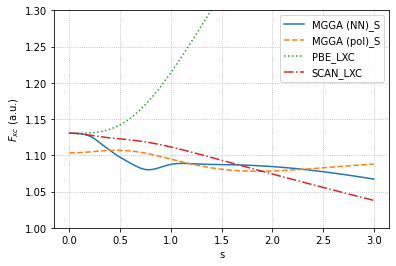

In [78]:
xc_s = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_REACTION2/xc')
xc_s_pol = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_POL_SHUTDOWN/xc')
plot_fxc({"MGGA (NN)_S": xc_s,"MGGA (pol)_S": xc_s_pol,"PBE_LXC":"GGA_X_PBE, GGA_C_PBE",'SCAN_LXC':"MGGA_X_SCAN, MGGA_C_SCAN"}, s_range=[0, 3],rs=[1],alpha_range=[1])
ylim(1.0,1.3)
# legend([])
grid(ls=':')
savefig('../figs/Fxc_mgga_alpha1.pdf',bbox_inches='tight')

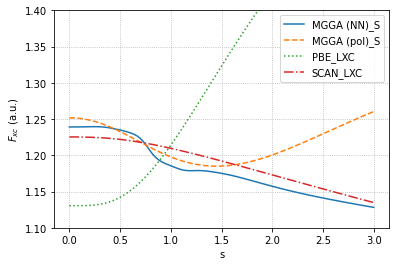

In [79]:
xc_s = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_REACTION2/xc')
xc_s_pol = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_POL_SHUTDOWN/xc')
plot_fxc({"MGGA (NN)_S": xc_s,"MGGA (pol)_S": xc_s_pol,"PBE_LXC":"GGA_X_PBE, GGA_C_PBE",'SCAN_LXC':"MGGA_X_SCAN, MGGA_C_SCAN"}, s_range=[0, 3],rs=[1],alpha_range=[0])
ylim(1.1,1.4)
# legend([])
grid(ls=':')
savefig('../figs/Fxc_mgga_alpha0.pdf',bbox_inches='tight')

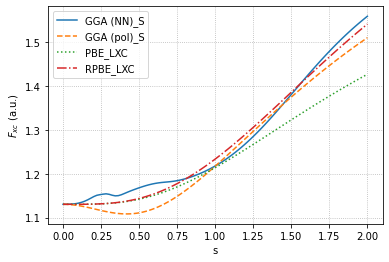

In [76]:
xc_s = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/GGA_RADICAL_4/xc')
xc_s_pol = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/log_gga_pol/GGA_POL/xc')
plot_fxc({"GGA (NN)_S": xc_s,"GGA (pol)_S": xc_s_pol,"PBE_LXC":"GGA_X_PBE, GGA_C_PBE","RPBE_LXC":"GGA_X_RPBE, GGA_C_PBE"}, s_range=[0, 2],rs=[1],alpha_range=None)
# ylim(1.0,1.3)
# legend([])
grid(ls=':')
savefig('../figs/Fxc_gga.pdf',bbox_inches='tight')

In [4]:
def plot_x_and_c(models, rs = [0.1, 1, 5], s_range=[0, 3], alpha_range=None):
    figsize(16,4)
    subplot(1,3,1)
    alpha_limited = [alpha_range[1]] if alpha_range is not None else None
    plot_fxc(models, rs, s_range, alpha_range=alpha_limited)
    subplot(1,3,2)
    plot_fxc(models, rs=[1], s_range=s_range, only = 0,alpha_range=alpha_range)
    ylabel('$F_{x}$ (a.u.)')
    subplot(1,3,3)
    plot_fxc(models, rs, s_range, only = 1,alpha_range=alpha_limited)
    ylabel('$F_{c}$ (a.u.)')

## GGA-KSR (NN)

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


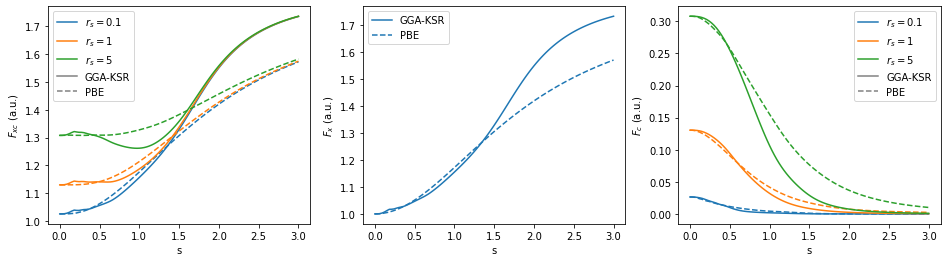

In [56]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga/2021-01-26_18:55:27.336476_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


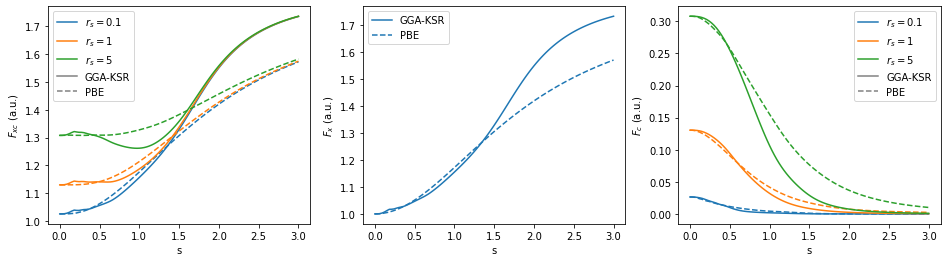

In [5]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga/2021-01-26_18:55:27.336476_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

## GGA-KSR (polynomial)

In [7]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_pol/',path='../exp/log_gga_pol0/2021-02-15_13:46:50.201073_val.chkpt',polynomial=True, ueg_limit=True ).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe_pol/


RuntimeError: Error(s) in loading state_dict for XC:
	Unexpected key(s) in state_dict: "exx_a". 
	size mismatch for grid_models.1.pars_ss: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for grid_models.1.pars_os: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([20]).

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_pol_freec/


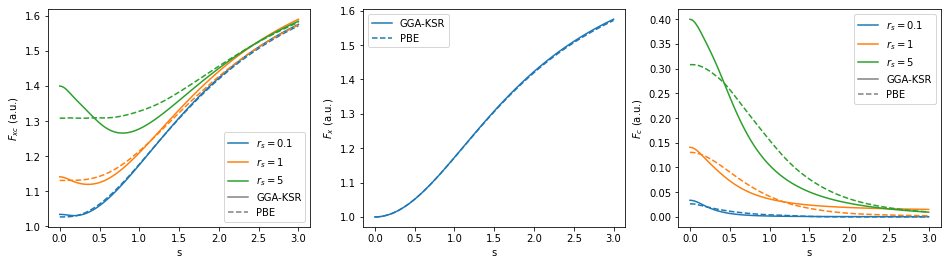

In [73]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_pol_freec/',path='../exp/log_gga_pol_freec/2021-02-12_16:23:57.613323_val.chkpt',
             polynomial=True, ueg_limit=True, freec=True ).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base},s_range=[0, 3])

## GGA-KSR (NN free)

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_free/


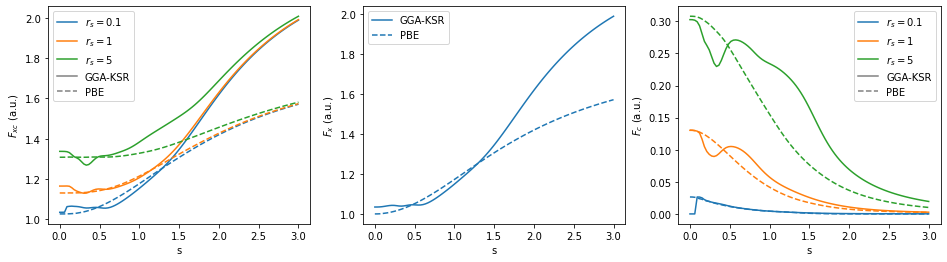

In [6]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_free/', path='../exp/log_gga_free/2021-02-02_11:41:40.985078_val.chkpt', ueg_limit=False).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

## MGGA-KSR(NN)

Loading pre-trained models from ../models/pretrained/scan/
Loading pre-trained models from ../models/pretrained/scan/


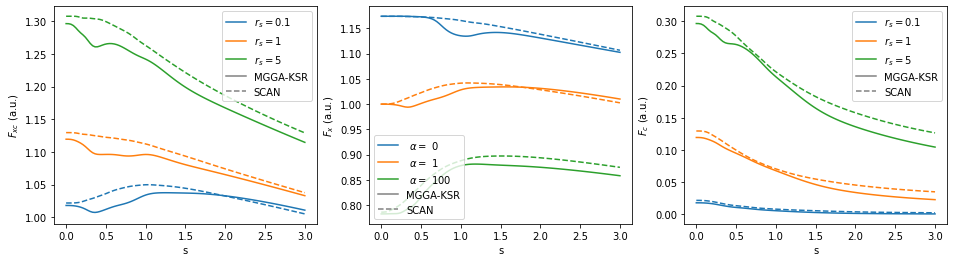

In [36]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan/', path='../exp/log_mgga/2021-02-04_22:23:20.359630_val.chkpt', ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0, 1, 100])

Loading pre-trained models from ../models/pretrained/scan/
Loading pre-trained models from ../models/pretrained/scan_freec/


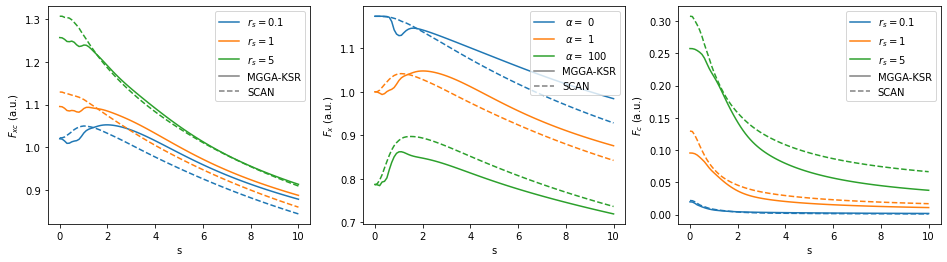

In [72]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan_freec/', path='../exp/log_mgga_freec/2021-02-13_18:07:30.075911_val.chkpt', ueg_limit=True, freec=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0, 1, 100], s_range=[0,10])

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


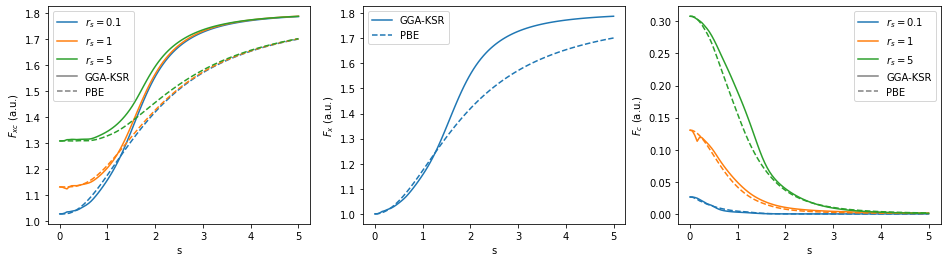

In [16]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_2/2021-02-08_09:46:52.113037_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base},s_range=[0,5])

Loading pre-trained models from ../models/pretrained/scan/
Loading pre-trained models from ../models/pretrained/scan_pol/


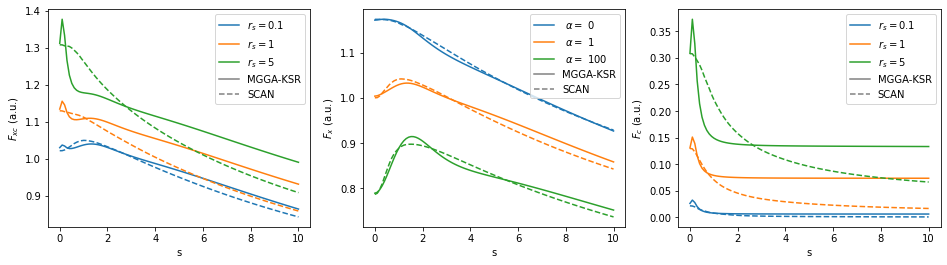

In [10]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan_pol/', polynomial=True, ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base},s_range=[0,10], alpha_range=[0, 1, 100])

Loading pre-trained models from ../models/pretrained/pbe_freec/
Loading pre-trained models from ../models/pretrained/pbe_freec/


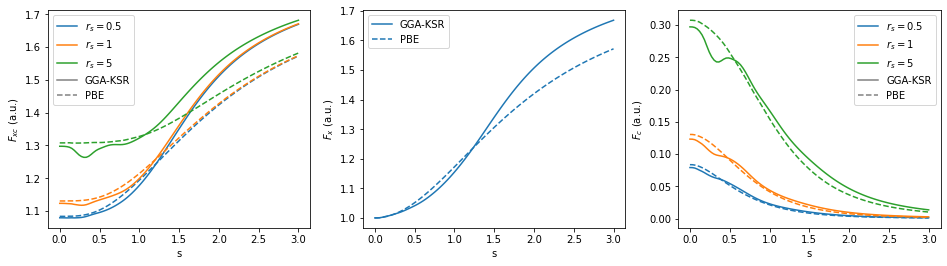

In [71]:
xc_base = get_scf('GGA','../models/pretrained/pbe_freec/',freec=True).xc
xc = get_scf('GGA','../models/pretrained/pbe_freec/', path='../exp/log_gga_freec_largestep/val.chkpt', ueg_limit=True, freec=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base}, rs =[0.5, 1, 5], s_range=[0.0, 3])

Loading pre-trained models from ../models/pretrained/pbe_freec/
Loading pre-trained models from ../models/pretrained/pbe_freec/


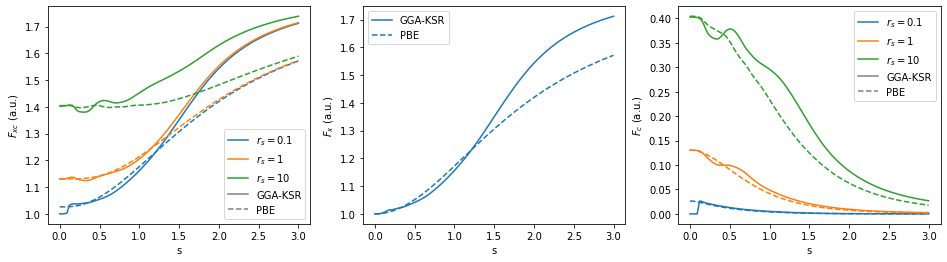

In [33]:
xc_base = get_scf('GGA','../models/pretrained/pbe_freec/',freec=True).xc
xc = get_scf('GGA','../models/pretrained/pbe_freec/', path='../exp/log_gga_freec_largestep/val2.chkpt', ueg_limit=True, freec=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base}, rs =[0.1, 1, 10], s_range=[0., 3])

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_pol/


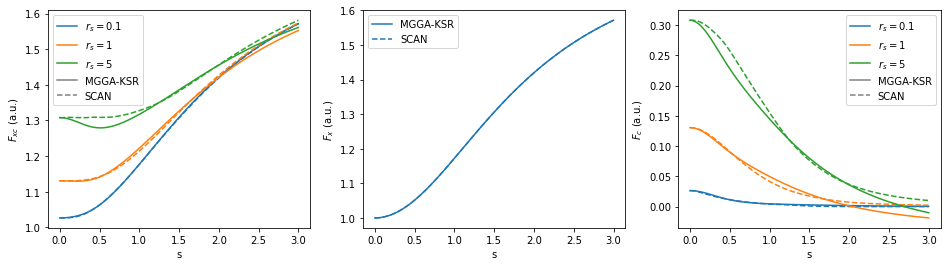

In [19]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_pol/', polynomial=True, ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base},s_range=[0,3])

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe/


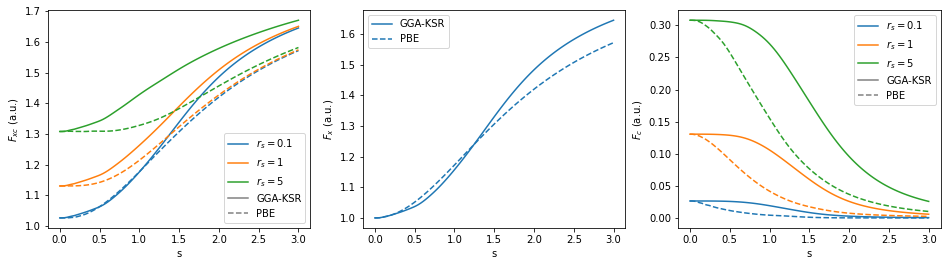

In [60]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_small/2021-02-10_09:13:58.808790_val.chkpt', ueg_limit=True).xc

plot_x_and_c({'GGA-KSR':xc, 'PBE':xc_base})

Loading pre-trained models from ../models/pretrained/pbe/
Loading pre-trained models from ../models/pretrained/pbe_pol_freec/


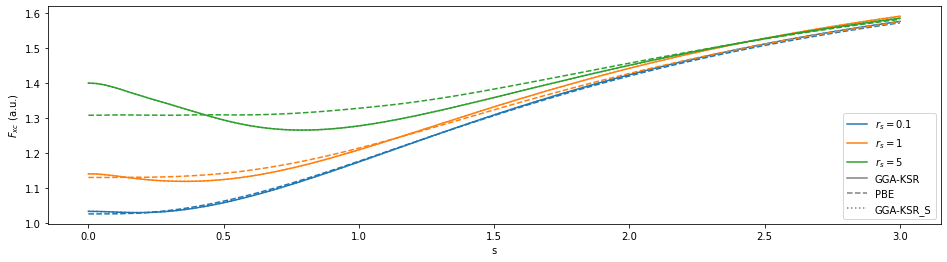

In [63]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe_pol_freec/',path='../exp/log_gga_pol_freec/2021-02-12_16:23:57.613323_val.chkpt',
             polynomial=True, ueg_limit=True, freec=True ).xc
xc_s = torch.jit.load('../exp/log_gga_pol_freec/GGA_POL_FREEC/xc')

plot_fxc({'GGA-KSR':xc, 'PBE':xc_base,'GGA-KSR_S':xc_s},s_range=[0, 3])

Loading pre-trained models from ../models/pretrained/pbe_freec/
Loading pre-trained models from ../models/pretrained/pbe_freec/


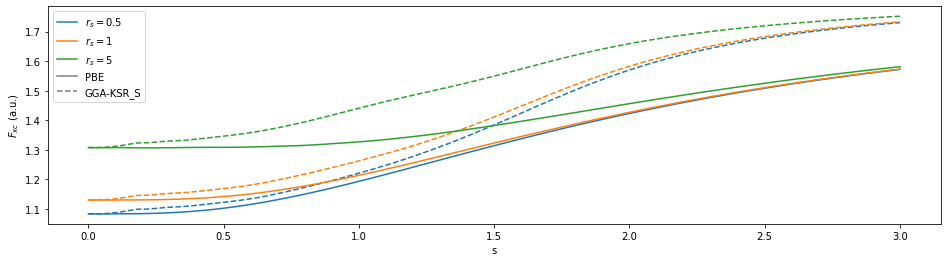

In [68]:
xc_base = get_scf('GGA','../models/pretrained/pbe_freec/',freec=True).xc
xc = get_scf('GGA','../models/pretrained/pbe_freec/', path='../exp/log_gga_freec/2021-02-10_14:57:13.563769_val.chkpt', ueg_limit=True, freec=True).xc
xc_s = torch.jit.load('../exp/log_gga_freec/GGA_FREEC_2/xc')
plot_fxc({'PBE':xc_base,'GGA-KSR_S':xc_s}, rs =[0.5, 1, 5], s_range=[0.0, 3])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/
FREEC True
Loading pre-trained models from ../models/pretrained/scan_freec/


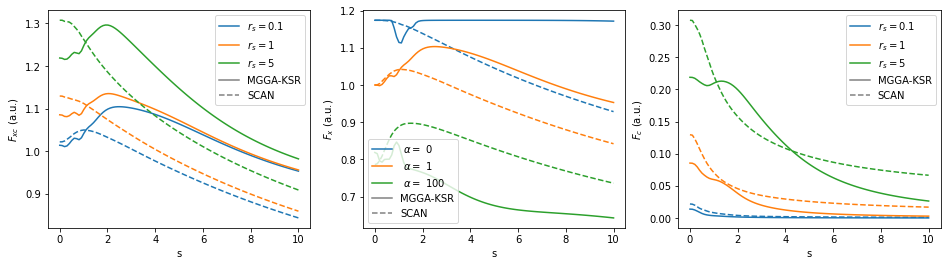

In [70]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan_freec/', path='../exp/log_mgga0/2021-02-16_10:27:28.000866_val.chkpt', ueg_limit=True, freec=True, hyb_par=0.1).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0, 1, 100], s_range=[0,10])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/
FREEC True
Loading pre-trained models from ../models/pretrained/scan_freec/


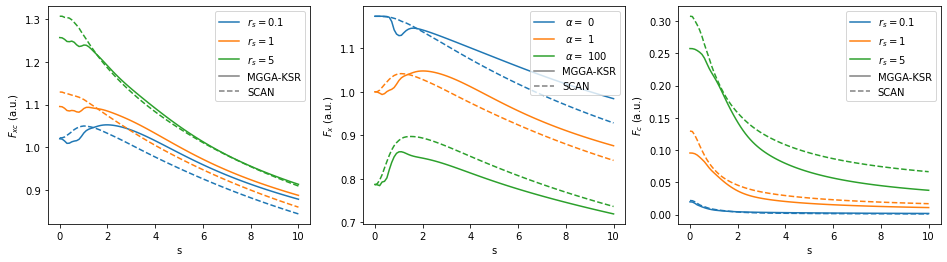

In [33]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan_freec/', path='../exp/log_mgga_freec/2021-02-13_18:07:30.075911_val.chkpt',ueg_limit=True, freec=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0, 1, 100], s_range=[0,10])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


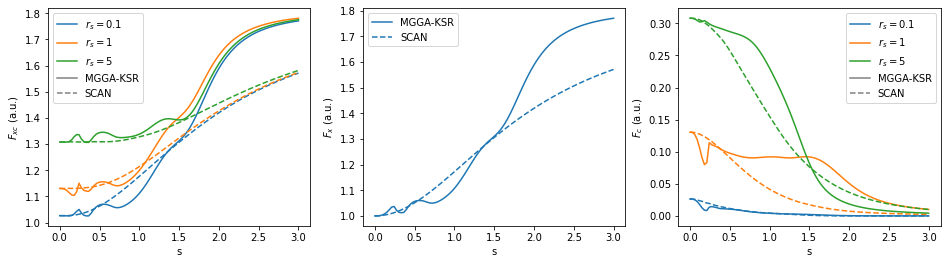

In [67]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/rho_test/2021-02-17_22:57:03.317246_current.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC True
Loading pre-trained models from ../models/pretrained/pbe/


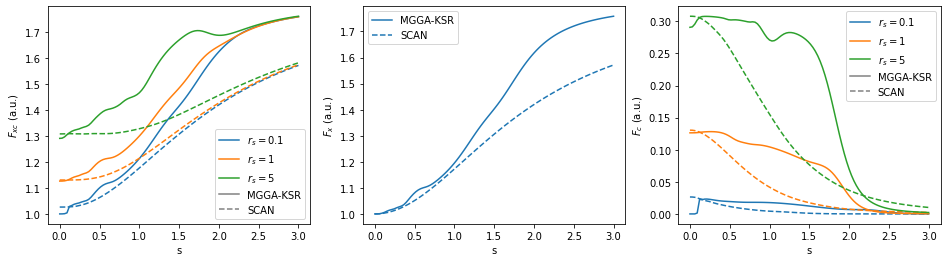

In [123]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/rho_test/2021-02-18_08:40:59.955524_current.chkpt',ueg_limit=True, freec=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


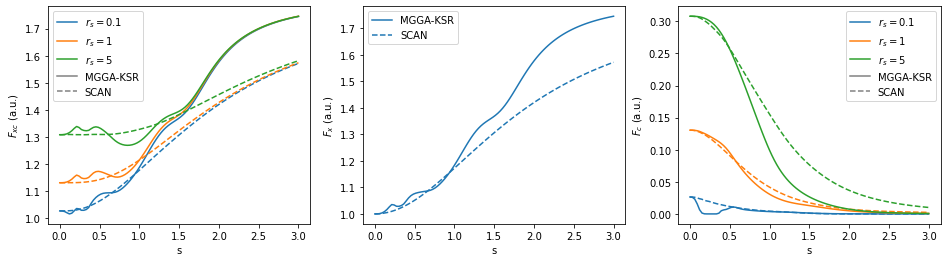

In [125]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/tiny_test/2021-02-18_12:36:50.495758_current.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


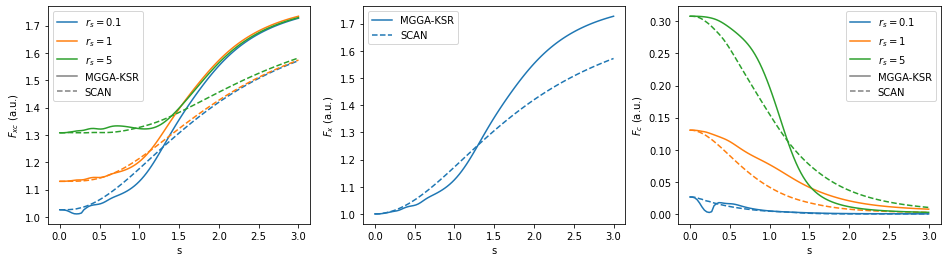

In [142]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_radical/2021-02-18_18:52:06.752789_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


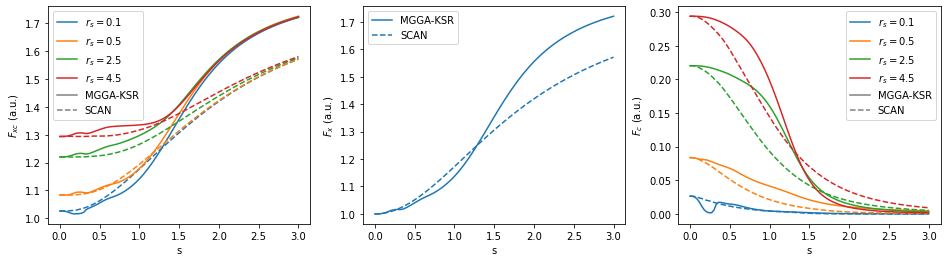

In [70]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_radical3/2021-02-22_18:38:24.552725_val.chkpt',ueg_limit=True).xc
# xc_s = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_radical3/2021-02-22_18:38:24.552725_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[.1, 0.5,2.5, 4.5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


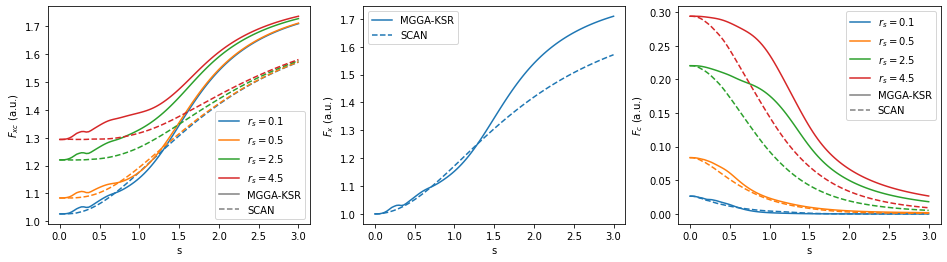

In [69]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_radical4/2021-02-23_20:02:20.270372_val.chkpt',ueg_limit=True).xc
# xc_s = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_radical3/2021-02-22_18:38:24.552725_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[.1, 0.5,2.5, 4.5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC True
Loading pre-trained models from ../models/pretrained/pbe/


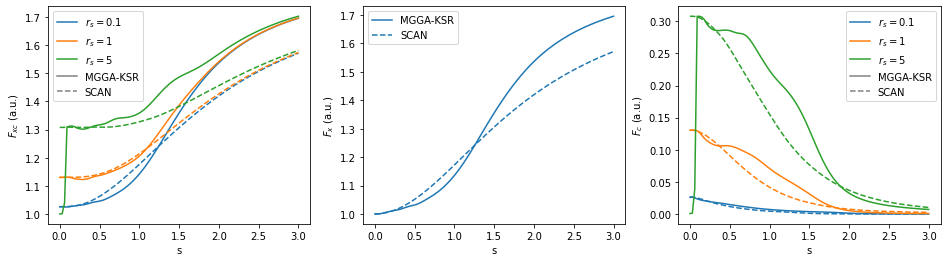

In [158]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_radical_freec/2021-02-19_10:56:34.398210_val.chkpt',ueg_limit=True, freec=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/
FREEC False
Loading pre-trained models from ../models/pretrained/scan/


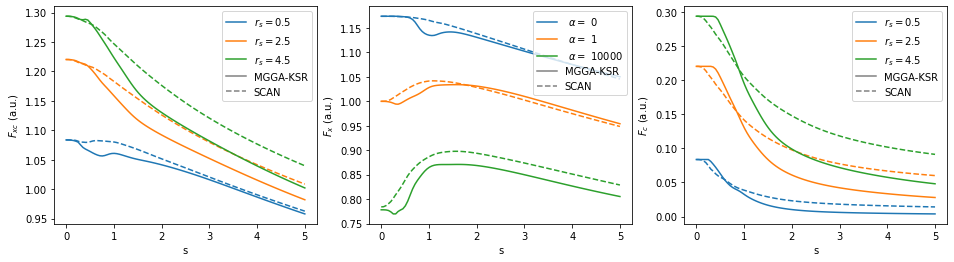

In [35]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan/', path='../exp/log_mgga/2021-02-04_22:23:20.359630_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0,1, 10000], s_range=[0,5], rs=[0.5,2.5, 4.5])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/
FREEC False
Loading pre-trained models from ../models/pretrained/scan/


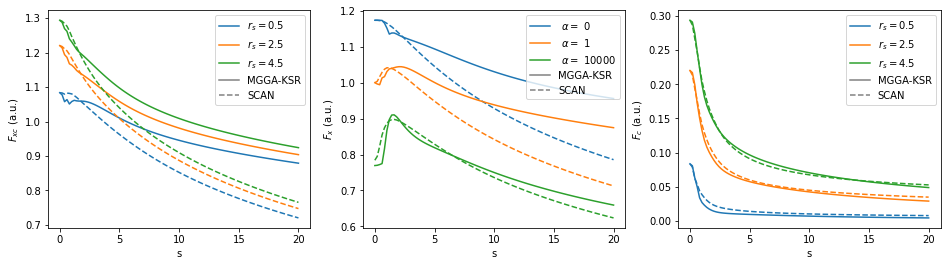

In [72]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan/', path='../exp/log_mgga_radical2/2021-02-24_14:41:37.488511_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0,1, 10000], s_range=[0,20], rs=[0.5,2.5, 4.5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe


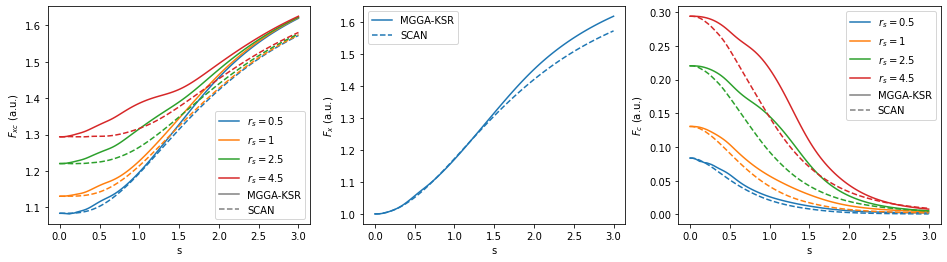

In [67]:
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc = get_scf('GGA','../models/pretrained/pbe', path='../exp/log_gga_radical_hyb/2021-02-23_14:55:28.595403_val.chkpt', ueg_limit=True, hyb_par=0.25).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0,3] ,rs=[ 0.5,1, 2.5, 4.5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbesol/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


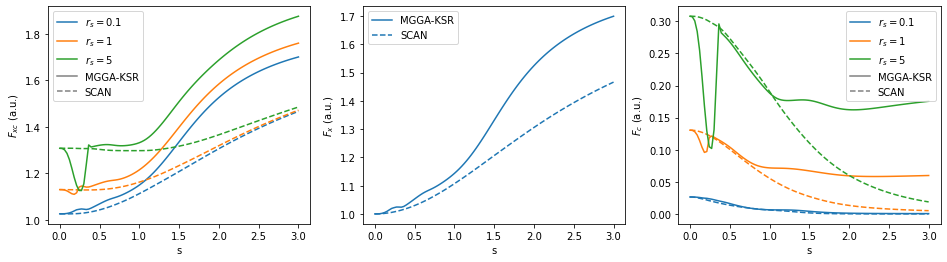

In [39]:
xc_base = get_scf('GGA','../models/pretrained/pbesol/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_reaction/2021-02-26_13:31:02.612357_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbesol/
FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


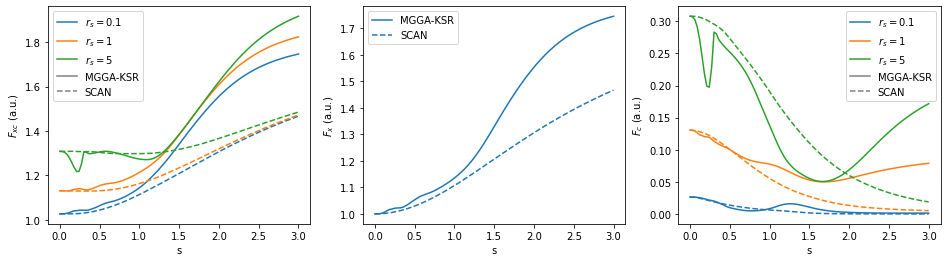

In [48]:
xc_base = get_scf('GGA','../models/pretrained/pbesol/').xc
xc = get_scf('GGA','../models/pretrained/pbe/', path='../exp/log_gga_reaction2/2021-02-27_09:42:16.479390_val.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


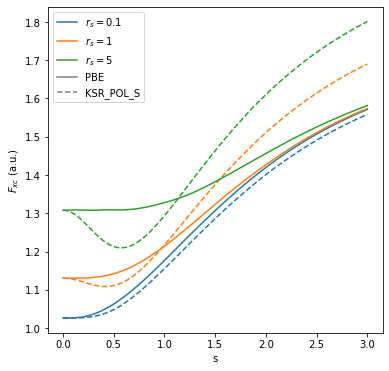

In [11]:
figsize(6,6)
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc_s = torch.jit.load('../exp/log_gga_pol/GGA_POL/xc')

plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/
FREEC False
Loading pre-trained models from ../models/pretrained/scan/


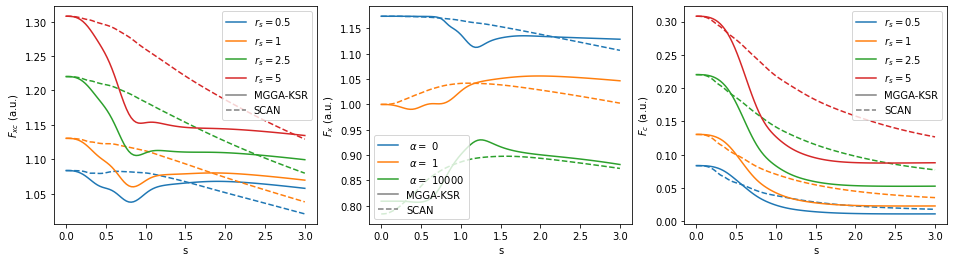

In [73]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan/', path='../exp/log_mgga_reaction/2021-02-28_14:41:33.176473_current.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0,1, 10000], s_range=[0,3], rs=[0.5, 1, 2.5, 5])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/
FREEC False
Loading pre-trained models from ../models/pretrained/scan/


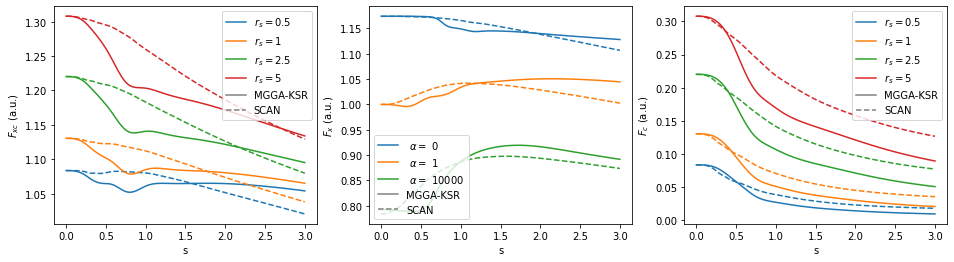

In [6]:
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc = get_scf('MGGA','../models/pretrained/scan/', path='../exp/log_mgga_reaction2/2021-03-02_08:23:20.895103_current.chkpt',ueg_limit=True).xc

plot_x_and_c({ 'MGGA-KSR':xc, 'SCAN':xc_base}, alpha_range=[0,1, 10000], s_range=[0,3], rs=[0.5, 1, 2.5, 5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


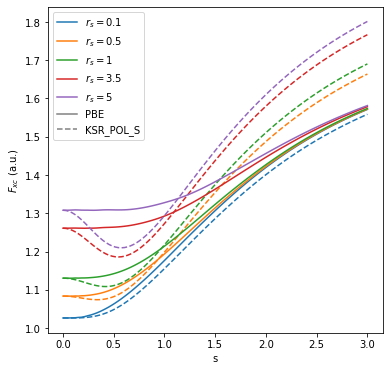

In [10]:
figsize(6,6)
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc_s = torch.jit.load('../exp/log_gga_pol/GGA_POL/xc')

plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[0.1,0.5, 1,3.5,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


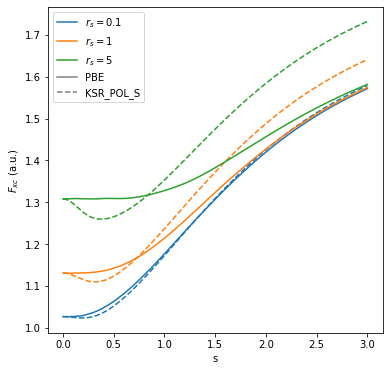

In [8]:
figsize(6,6)
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc_s = torch.jit.load('../exp/GGA_POL_REACTION/xc')

plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/pbe/


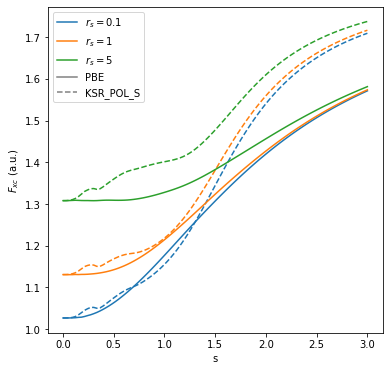

In [9]:
figsize(6,6)
xc_base = get_scf('GGA','../models/pretrained/pbe/').xc
xc_s = torch.jit.load('/gpfs/home/smdick/smdick/L20/GGA_RADICAL/GGA_XC_CUSTOM/xc')

plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[0.1,1,5])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/


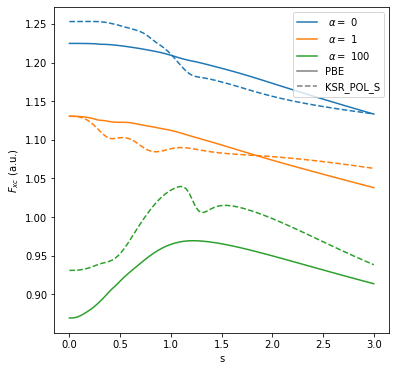

In [20]:
figsize(6,6)
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc_s = torch.jit.load('/gpfs/home/smdick/smdick/L20/MGGA_RADICAL/MGGA_XC_METACUSTOM/xc')
# xc_s = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_RADICAL2/xc')
plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[1],alpha_range=[0,1,100])

FREEC False
Loading pre-trained models from ../models/pretrained/scan/


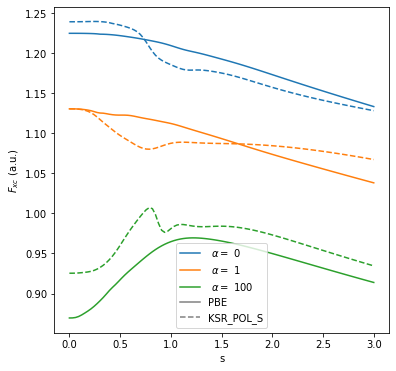

In [29]:
figsize(6,6)
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
# xc_s = torch.jit.load('/gpfs/home/smdick/smdick/L20/MGGA_RADICAL/MGGA_XC_REACTION2/xc')
xc_s = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_REACTION2/xc')
plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[1],alpha_range=[0,1,100])

<ipython-input-35-7c0c523ed692>:59: RuntimeWarning: invalid value encountered in true_divide
  ax = plot(s, exc/e_heg,


ValueError: x and y must have same first dimension, but have shapes torch.Size([100]) and (9,)

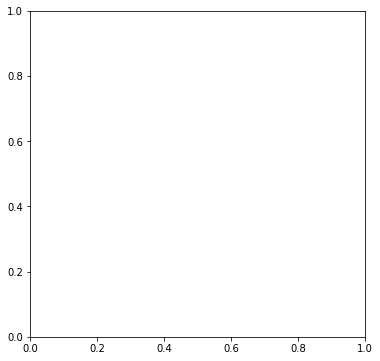

In [36]:
plot_fxc({'SCAN':"MGGA_X_SCAN"}, s_range=[0, 3],rs=[1],alpha_range=[0,1,100],libxc=True)

FREEC False
Loading pre-trained models from ../models/pretrained/scan/


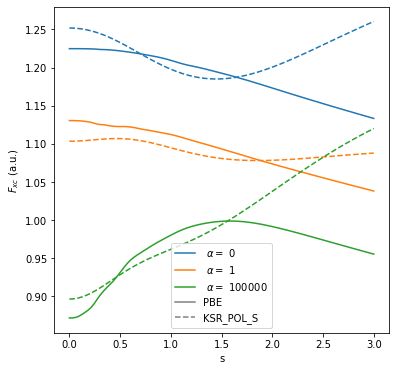

In [26]:
figsize(6,6)
xc_base = get_scf('MGGA','../models/pretrained/scan/').xc
xc_s = torch.jit.load('/gpfs/home/smdick/smdick/L20/MGGA_POL/MGGA_XC_METACUSTOM/xc')
# xc_s = torch.jit.load('/gpfs/home/smdick/dpyscf/exp/MGGA_RADICAL2/xc')
plot_fxc({'PBE':xc_base, 'KSR_POL_S':xc_s}, s_range=[0, 3],rs=[1],alpha_range=[0,1,100000])